In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

plt.rcParams['font.family']='FangSong'
plt.rcParams['axes.unicode_minus']=False

图片大小为: (2272, 1704)


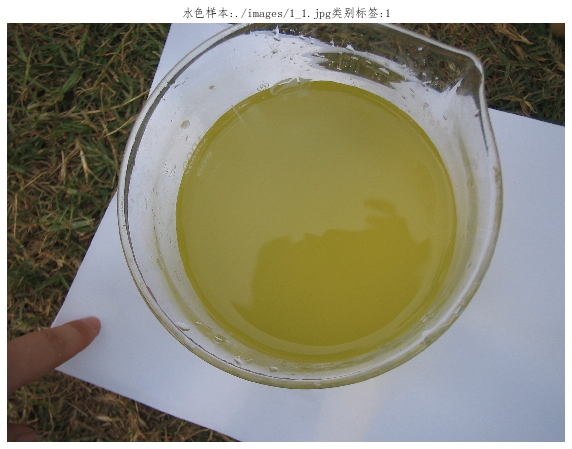

In [2]:
#加载数据，看看目录下的图片
imgFile='./images/1_1.jpg'
img=Image.open(imgFile)
print("图片大小为:",img.size)
plt.figure(figsize=(10,8))
plt.imshow(img)
plt.title("水色样本:"+imgFile+"类别标签:"+str(imgFile[9]))

#不显示坐标轴
plt.axis('off')
plt.show()

In [3]:
# 开始对图像的颜色矩特征进行提取

# 通过对数据图像的观察，决定选取每张图像中心处的图像进行颜色矩特征提取

def img_extract():
    input_path='./images'
    output_path='./result.csv'
    result=[]
    imglist=os.listdir(input_path)
    #print(imglist) 得到类似于1_1.jpg这样的文件名,其中1_1表示属于1类别的第一张图片
    for i in range(len(imglist)):
        #开始把类别和第几张图片分开
        num=imglist[i].rstrip('.jpg').split('_')
        #print(num) 得到['1','1']这样的列表
        #把字符串列表转换为数值型
        num=[int(x) for x in num]
        
        #开始图像分割
        img=Image.open(input_path+'/'+imglist[i])
        h,w=img.size
        #取图片中心100*100的图像
        #关于crop的介绍:https://blog.csdn.net/banxia1995/article/details/85330212
        box=[h/2-50,w/2-50,h/2+50,w/2+50]
        small=img.crop(box)
        
        #提取颜色特征
        rgb=np.array(small)/[255.0,255.0,255.0]
        #print(rgb)
        #一阶颜色矩
        first_order=1.0*(rgb.sum(axis=0).sum(axis=0))/10000
        err=rgb-first_order
        #print(first_order)
        
        #二阶颜色矩
        second_order=np.sqrt(1.0*(np.power(err,2)).sum(axis=0).sum(axis=0)/10000)
        
        #三阶颜色矩
        third_order=1.0*(pow(err,3).sum(axis=0).sum(axis=0))/10000
        third_order=np.cbrt(abs(third_order))*-1.0
        #print(third_order)
        
        res=np.concatenate((num,first_order,second_order,third_order))
        result.append(res)
        
    #保存到csv文件G
    names=['水质类别','序号','R通道一阶矩','G通道一阶矩','B通道一阶矩',
           'R通道二阶矩','G通道二阶矩','B通道二阶矩',
           'R通道三阶矩','G通道三阶矩','B通道三阶矩']

    df=pd.DataFrame(result,columns=names)
    #print(df)
    df.to_csv(output_path,encoding='utf-8',index=False)
    
img_extract()

In [2]:
# 开始导入我们做好的特征数据集，进行数据集划分并建模
from sklearn.model_selection import  train_test_split
from sklearn import svm
from sklearn import metrics


data=pd.read_csv('./result.csv',encoding='utf-8')
data.head()

,水质类别,序号,R通道一阶矩,G通道一阶矩,B通道一阶矩,R通道二阶矩,G通道二阶矩,B通道二阶矩,R通道三阶矩,G通道三阶矩,B通道三阶矩
0,1.0,1.0,0.582761,0.543679,0.252429,0.014219,0.016178,0.041121,-0.012616,-0.016063,-0.041421
1,1.0,10.0,0.641878,0.570779,0.213561,0.015386,0.011118,0.013643,-0.009581,-0.003777,-0.003660
2,1.0,11.0,0.603720,0.576788,0.282187,0.008662,0.007072,0.012218,-0.004718,-0.002625,-0.009478
3,1.0,12.0,0.589708,0.593720,0.252203,0.007903,0.005937,0.010584,-0.003378,-0.003397,-0.005270
4,1.0,13.0,0.591129,0.592054,0.253430,0.007462,0.006502,0.012149,-0.001343,-0.002168,-0.004776


In [3]:
#因为数据很小，为了增大数据区分度所以对X乘以30，避免过拟合
X=data.iloc[:,2:]*30
Y=data['水质类别']
Y=Y.astype(int)
X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.3,random_state=2)
print(X_train.shape,X_test.shape)

(142, 9) (61, 9)


In [6]:
#先不加任何参数来看看模型效果
model=svm.SVC()
model.fit(X_train,y_train)

train_pred=model.predict(X_train)
test_pred=model.predict(X_test)


print('----------模型在训练集的结果-------')
train_acc=metrics.accuracy_score(y_train,train_pred)
train_cm=metrics.confusion_matrix(y_train,train_pred)
train_report=metrics.classification_report(y_train,train_pred)
print("训练集准确率为:",train_acc)
print("-----------------")
print("训练集混淆矩阵:",train_cm)
print("-----------------")
print("训练集分类报告:",train_report)



print('----------模型在测试集的结果-------')
test_acc=metrics.accuracy_score(y_test,test_pred)
test_cm=metrics.confusion_matrix(y_test,test_pred)
test_report=metrics.classification_report(y_test,test_pred)
print("测试集准确率为:",test_acc)
print("-----------------")
print("测试集混淆矩阵:",test_cm)
print("-----------------")
print("测试集分类报告:",test_report)

----------模型在训练集的结果-------
训练集准确率为: 0.7605633802816901
-----------------
训练集混淆矩阵: [[18  2 11  0  0]
 [ 0 35  1  0  0]
 [ 0  0 55  0  0]
 [ 0  0 15  0  0]
 [ 0  0  4  1  0]]
-----------------
训练集分类报告:               precision    recall  f1-score   support

           1       1.00      0.58      0.73        31
           2       0.95      0.97      0.96        36
           3       0.64      1.00      0.78        55
           4       0.00      0.00      0.00        15
           5       0.00      0.00      0.00         5

    accuracy                           0.76       142
   macro avg       0.52      0.51      0.49       142
weighted avg       0.71      0.76      0.71       142

----------模型在测试集的结果-------
测试集准确率为: 0.7377049180327869
-----------------
测试集混淆矩阵: [[15  0  5  0  0]
 [ 0  7  1  0  0]
 [ 0  0 23  0  0]
 [ 0  0  9  0  0]
 [ 0  1  0  0  0]]
-----------------
测试集分类报告:               precision    recall  f1-score   support

           1       1.00      0.75      0.86        20
  

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [8]:
#混淆矩阵可视化
import seaborn as sns

def plot_confusion_matrix(confusion_mat):
    df_cm = pd.DataFrame(confusion_mat,index=[1,2,3,4,5],columns=[1,2,3,4,5])
    ax = sns.heatmap(df_cm,annot=True,fmt='.20g')
    ax.set_title('混淆矩阵')
    ax.set_xlabel('预测标签')
    ax.set_ylabel('真实标签')
    plt.show()

最好的超参数: {'C': 1, 'degree': 2, 'gamma': 0.1, 'kernel': 'poly'}
最好的分数为: 0.9788177339901478
----------模型在训练集的结果-------
训练集准确率为: 1.0
-----------------
训练集混淆矩阵: [[31  0  0  0  0]
 [ 0 36  0  0  0]
 [ 0  0 55  0  0]
 [ 0  0  0 15  0]
 [ 0  0  0  0  5]]
-----------------
训练集分类报告:               precision    recall  f1-score   support

           1       1.00      1.00      1.00        31
           2       1.00      1.00      1.00        36
           3       1.00      1.00      1.00        55
           4       1.00      1.00      1.00        15
           5       1.00      1.00      1.00         5

    accuracy                           1.00       142
   macro avg       1.00      1.00      1.00       142
weighted avg       1.00      1.00      1.00       142

----------模型在测试集的结果-------
测试集准确率为: 0.9508196721311475
-----------------
测试集混淆矩阵: [[18  0  2  0  0]
 [ 0  8  0  0  0]
 [ 0  0 23  0  0]
 [ 0  0  0  9  0]
 [ 0  1  0  0  0]]
-----------------
测试集分类报告:               precision    recall  f1

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


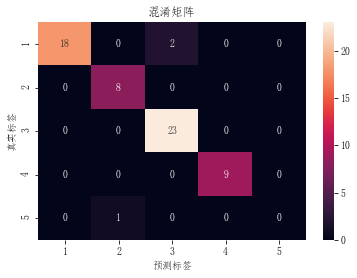

In [18]:
#发现模型性能其实并不好，开始试试网格搜索进行超参数优化
from sklearn.model_selection import GridSearchCV

parameters =[{'kernel': ['linear','rbf','poly'],'C': [1, 10, 100, 1000,1200],'gamma':[1,0.1, 0.01, 0.001],'degree':[2,3,5]}]

clf=GridSearchCV(estimator=svm.SVC(),param_grid=parameters,cv=5,scoring='accuracy')
clf.fit(X_train,y_train)

print("最好的超参数:",clf.best_params_)
print("最好的分数为:",clf.best_score_)

#使用最好的模型
best_svc=clf.best_estimator_
train_pred=best_svc.predict(X_train)
test_pred=best_svc.predict(X_test)


print('----------模型在训练集的结果-------')
train_acc=metrics.accuracy_score(y_train,train_pred)
train_cm=metrics.confusion_matrix(y_train,train_pred)
train_report=metrics.classification_report(y_train,train_pred)
print("训练集准确率为:",train_acc)
print("-----------------")
print("训练集混淆矩阵:",train_cm)
print("-----------------")
print("训练集分类报告:",train_report)



print('----------模型在测试集的结果-------')
test_acc=metrics.accuracy_score(y_test,test_pred)
test_cm=metrics.confusion_matrix(y_test,test_pred)
test_report=metrics.classification_report(y_test,test_pred)
print("测试集准确率为:",test_acc)
print("-----------------")
print("测试集混淆矩阵:",test_cm)
print("-----------------")
print("测试集分类报告:",test_report)


plot_confusion_matrix(test_cm)

----------模型在训练集的结果-------
训练集准确率为: 0.9788732394366197
-----------------
训练集混淆矩阵: [[31  0  0  0  0]
 [ 0 36  0  0  0]
 [ 1  0 54  0  0]
 [ 0  0  2 13  0]
 [ 0  0  0  0  5]]
-----------------
训练集分类报告:               precision    recall  f1-score   support

           1       0.97      1.00      0.98        31
           2       1.00      1.00      1.00        36
           3       0.96      0.98      0.97        55
           4       1.00      0.87      0.93        15
           5       1.00      1.00      1.00         5

    accuracy                           0.98       142
   macro avg       0.99      0.97      0.98       142
weighted avg       0.98      0.98      0.98       142

----------模型在测试集的结果-------
测试集准确率为: 0.8360655737704918
-----------------
测试集混淆矩阵: [[18  1  1  0  0]
 [ 0  8  0  0  0]
 [ 4  0 19  0  0]
 [ 0  1  2  6  0]
 [ 0  1  0  0  0]]
-----------------
测试集分类报告:               precision    recall  f1-score   support

           1       0.82      0.90      0.86        20
  

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


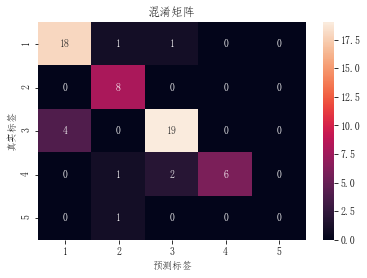

In [22]:
from sklearn.neural_network import MLPClassifier

mlp=MLPClassifier(hidden_layer_sizes=(40,30,60,50),max_iter=5000,random_state=200)
mlp.fit(X_train,y_train)
train_pred=mlp.predict(X_train)
test_pred=mlp.predict(X_test)

print('----------模型在训练集的结果-------')
train_acc=metrics.accuracy_score(y_train,train_pred)
train_cm=metrics.confusion_matrix(y_train,train_pred)
train_report=metrics.classification_report(y_train,train_pred)
print("训练集准确率为:",train_acc)
print("-----------------")
print("训练集混淆矩阵:",train_cm)
print("-----------------")
print("训练集分类报告:",train_report)



print('----------模型在测试集的结果-------')
test_acc=metrics.accuracy_score(y_test,test_pred)
test_cm=metrics.confusion_matrix(y_test,test_pred)
test_report=metrics.classification_report(y_test,test_pred)
print("测试集准确率为:",test_acc)
print("-----------------")
print("测试集混淆矩阵:",test_cm)
print("-----------------")
print("测试集分类报告:",test_report)


plot_confusion_matrix(test_cm)

In [133]:
#再使用神经网络试试
from keras.preprocessing.image import img_to_array#图片转为array
from keras.utils import to_categorical#相当于one-hot
from imutils import paths
import cv2
import numpy as np
import random
import os

def load_data(norm_size,class_num):
    data = []
    label = []
    input_path='./images'
    image_paths=os.listdir(input_path)
    for each_path in image_paths:
        #print('./images'+'/'+each_path)
        image = cv2.imread('./images'+'/'+each_path)
        image = cv2.resize(image,(norm_size,norm_size))
        image = img_to_array(image)
        data.append(image)
        maker = int(each_path[0])
        label.append(maker)
    #归一化
    data = np.array(data,dtype="float")/255.0
    label = np.array(label)
    #进行one-hot编码
    label = to_categorical(label)
    return data,label



#搭建模型
import keras
from keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten
from keras.models import Sequential
import keras.backend as K

class Lenet:
    def neural(channel,height,width):
        input_shape = (channel,height,width)
        if K.image_data_format() == "channels_last":#确认输入维度,就是channel是在开头，还是结尾
            input_shape = (height,width,channel)
        model = Sequential()
        model.add(Conv2D(16,(5,5),padding="same",activation="relu",input_shape=input_shape,name="conv1"))
        model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2),name="pool1"))
        model.add(Conv2D(32,(5,5),padding="same",activation="relu",name="conv2",))
        model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2),name="pool2"))
        model.add(Flatten())
        model.add(Dense(16,activation="relu"))
        model.add(Dense(6,activation="softmax"))
        return model

Epoch 1/100
7/7 [==============================] - 0s 66ms/step - loss: 1.6143 - accuracy: 0.3622 - val_loss: 1.4825 - val_accuracy: 0.3842
Epoch 2/100
7/7 [==============================] - 0s 29ms/step - loss: 1.4847 - accuracy: 0.3896 - val_loss: 1.4173 - val_accuracy: 0.3842
Epoch 3/100
7/7 [==============================] - 0s 20ms/step - loss: 1.3998 - accuracy: 0.3771 - val_loss: 1.3851 - val_accuracy: 0.3842
Epoch 4/100
7/7 [==============================] - 0s 14ms/step - loss: 1.3568 - accuracy: 0.3878 - val_loss: 1.3560 - val_accuracy: 0.3842
Epoch 5/100
7/7 [==============================] - 0s 27ms/step - loss: 1.3406 - accuracy: 0.4057 - val_loss: 1.3161 - val_accuracy: 0.4089
Epoch 6/100
7/7 [==============================] - 0s 13ms/step - loss: 1.3847 - accuracy: 0.3657 - val_loss: 1.2414 - val_accuracy: 0.3842
Epoch 7/100
7/7 [==============================] - 0s 12ms/step - loss: 1.2606 - accuracy: 0.4057 - val_loss: 1.1937 - val_accuracy: 0.4089
Epoch 8/100
7/7 [===

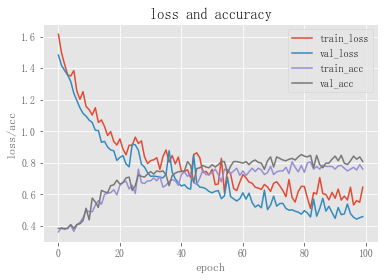

In [138]:
#训练
import matplotlib.pylab as plt
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import sys

def train(aug, model,train_x,train_y,test_x,test_y):

    model.compile(loss="categorical_crossentropy",
                  optimizer="Adam",metrics=["accuracy"])#配置
    #model.fit(train_x,train_y,batch_size,epochs,validation_data=(test_x,test_y))
    _history = model.fit_generator(aug.flow(train_x,train_y,batch_size=batch_size),
                        validation_data=(test_x,test_y),steps_per_epoch=len(train_x)//batch_size,
                        epochs=epochs,verbose=1)
    model.save("./image_model.h5")
    plt.style.use("ggplot")#matplotlib的美化样式
    plt.figure()
    N = epochs
    print(_history.history.keys())
    plt.plot(np.arange(0,N),_history.history["loss"],label ="train_loss")
    plt.plot(np.arange(0,N),_history.history["val_loss"],label="val_loss")
    plt.plot(np.arange(0,N),_history.history["accuracy"],label="train_acc")
    plt.plot(np.arange(0,N),_history.history["val_accuracy"],label="val_acc")
    plt.title("loss and accuracy")
    plt.xlabel("epoch")
    plt.ylabel("loss/acc")
    plt.legend(loc="best")
    plt.show()

if __name__ =="__main__":
    channel = 3
    height = 32
    width = 32
    class_num =6
    norm_size = 32
    batch_size = 28
    epochs = 100
    model = Lenet.neural(channel=channel, height=height,
                         width=width)#网络
    train_x, train_y = load_data(norm_size, class_num)

    aug = ImageDataGenerator(rotation_range=30,width_shift_range=0.1,
                       height_shift_range=0.1,shear_range=0.2,zoom_range=0.2,
                       horizontal_flip=True,fill_mode="nearest")#数据增强
    train(aug,model,train_x,train_y,train_x,train_y)#训练

In [4]:
import tensorflow as tf
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Conv2D, Dense, AveragePooling2D, Flatten, BatchNormalization
from keras.optimizers import Adam


X_train = X_train.astype('float32').values.reshape(len(X_train),3,3,1)
X_test = X_test.astype('float32').values.reshape(len(X_test),3,3,1)

#因为类别不是从0开始编号，所以进行one-hot编码时减1
Y_train = np_utils.to_categorical(y_train-1)
Y_test = np_utils.to_categorical(y_test-1)

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarning: Passi

In [5]:
model = Sequential()
model.add(Conv2D(6,6, strides=1, padding='same', input_shape=(3,3,1), activation='relu'))
model.add(AveragePooling2D(3,2, padding='same'))
model.add(BatchNormalization())
 
model.add(Conv2D(9,9, strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(AveragePooling2D(12,3, padding='same'))
model.add(Flatten())
 
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(5, activation='softmax'))


adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999,epsilon=1e-8)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
print('Training')
result = model.fit(X_train, Y_train, epochs=50, batch_size=6,validation_split=0.1,shuffle=True)
 
print('Testing')
loss, accuracy = model.evaluate(X_test, Y_test)
print('loss, accuracy', loss, accuracy)

Instructions for updating:
Colocations handled automatically by placer.
Training
Instructions for updating:
Use tf.cast instead.
Train on 127 samples, validate on 15 samples
Epoch 1/50
127/127 [==============================] - 4s 28ms/step - loss: 1.5701 - accuracy: 0.2283 - val_loss: 1.5370 - val_accuracy: 0.2667
Epoch 2/50
127/127 [==============================] - 0s 992us/step - loss: 1.5035 - accuracy: 0.2677 - val_loss: 1.5001 - val_accuracy: 0.2667
Epoch 3/50
127/127 [==============================] - 0s 1ms/step - loss: 1.4210 - accuracy: 0.4961 - val_loss: 1.4605 - val_accuracy: 0.3333
Epoch 4/50
127/127 [==============================] - 0s 1ms/step - loss: 1.3272 - accuracy: 0.5433 - val_loss: 1.4323 - val_accuracy: 0.6667
Epoch 5/50
127/127 [==============================] - 0s 984us/step - loss: 1.2018 - accuracy: 0.7480 - val_loss: 1.4016 - val_accuracy: 0.6000
Epoch 6/50
127/127 [==============================] - 0s 1ms/step - loss: 1.1386 - accuracy: 0.7165 - val_loss:

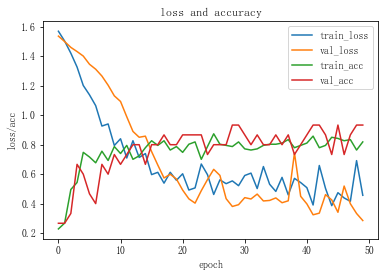

In [6]:
N=50
plt.plot(np.arange(0,N),result.history["loss"],label ="train_loss")
plt.plot(np.arange(0,N),result.history["val_loss"],label="val_loss")
plt.plot(np.arange(0,N),result.history["accuracy"],label="train_acc")
plt.plot(np.arange(0,N),result.history["val_accuracy"],label="val_acc")
plt.title("loss and accuracy")
plt.xlabel("epoch")
plt.ylabel("loss/acc")
plt.legend(loc="best")
plt.show()

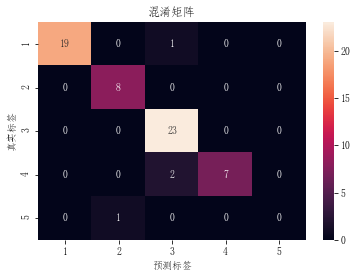

In [9]:
cnn_pred=model.predict(X_test)
cnn_pred=np.argmax(cnn_pred,axis=1)+1

cnn_testcm=metrics.confusion_matrix(y_test,cnn_pred)
plot_confusion_matrix(cnn_testcm)